# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

Imports:

In [74]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
import seaborn as sns
sns.set_style("darkgrid")
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor


from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
from math import sqrt


Utilities:

In [75]:
def plotModelResults(model, X_train, X_test, y_train, y_test, plot_intervals=False, plot_anomalies=False):
    prediction = model.predict(X_test)
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    if plot_intervals:
        tscv = TimeSeriesSplit(n_splits=5)
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    mape = mean_absolute_percentage_error(prediction, y_test)
    rmse = rmse_error(prediction, y_test)
    plt.title(f"MAPE {mape:.2f}%, RMSE {rmse:.2f}")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True)

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def rmse_error(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

In [76]:
data = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0])
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


## Analysis

Let's print some information about our dataset:

In [77]:
data.sort_index(inplace=True)

data = data.resample('60min').sum()
#.resample('60min', on='TIME').mean()

print(data.info())
print()
print("Shape",data.shape)
print()
print("Nans:",data.isna().sum())
print()
print("Duplicates in datetime:", data.index.duplicated().sum())
print()
print("Max daily orders:", data.num_orders.max())
print()
print("Min daily orders:",  data.num_orders.min())
print()
print("Avrg daily orders:",  data.num_orders.mean())
print()
print("Is monotonic:", data.index.is_monotonic)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: 60T
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB
None

Shape (4416, 1)

Nans: num_orders    0
dtype: int64

Duplicates in datetime: 0

Max daily orders: 462

Min daily orders: 0

Avrg daily orders: 84.42278079710145

Is monotonic: True


<div class="alert alert-success">
<b>Reviewer's comment</b>

The data was loaded and correctly resampled

</div>

Let's resample and plot our data by days, weeks and hours:

In [78]:
monthly= data.resample('1M').sum()
weekly = data.resample('1W').sum()
hourly = data.resample('1H').sum()

<AxesSubplot:xlabel='datetime', ylabel='num_orders'>

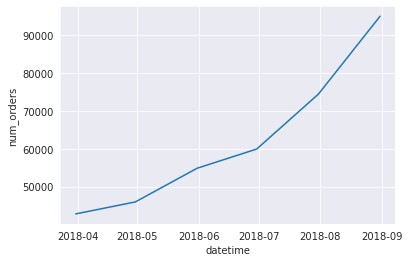

In [79]:
# Monthly orders:

sns.lineplot(x=monthly.index,y=monthly['num_orders'])

<AxesSubplot:xlabel='datetime', ylabel='num_orders'>

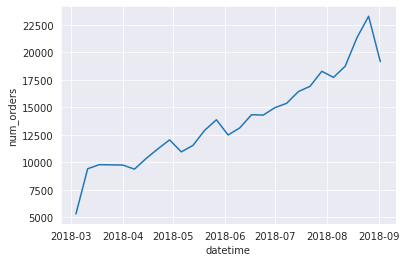

In [80]:
# Weekly orders
sns.lineplot(x=weekly.index,y=weekly['num_orders'])

In [81]:
data_2 = data.copy()
data_2 = data_2.resample('1H').sum()
data_2['rolling_mean'] = data_2['num_orders'].shift().rolling(12).mean()
data_2['std'] = data_2['num_orders'].rolling(12).std()
data_2 = data_2.dropna()



Text(0.5, 1.0, 'Daily Seasonality')

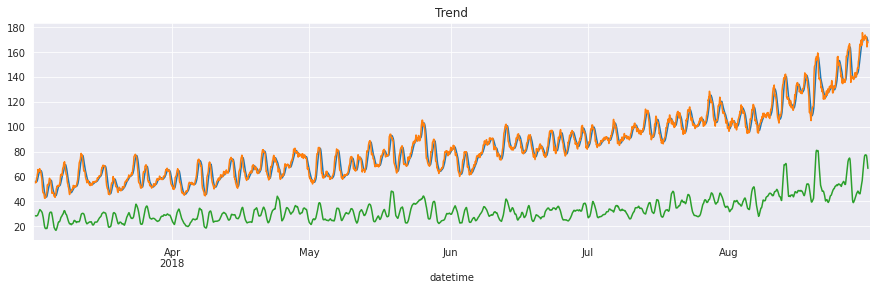

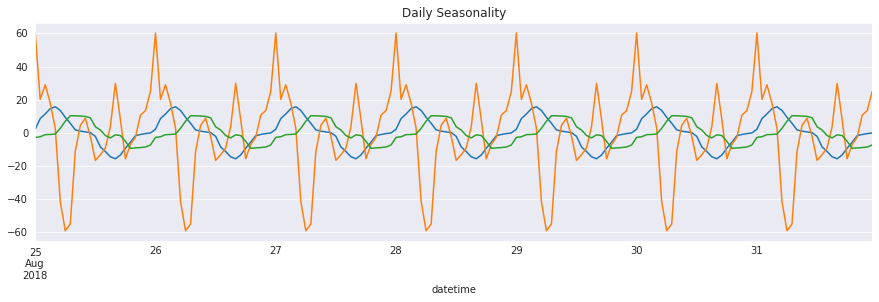

In [82]:

decomposed_rolling_mean = seasonal_decompose(data_2["rolling_mean"])
decomposed_num_orders = seasonal_decompose(data_2["num_orders"])
decomposed_std = seasonal_decompose(data_2["std"])

decomposed_rolling_mean.trend.plot(title='Trend', figsize=(15,4))
decomposed_num_orders.trend.plot(title='Trend', figsize=(15,4))
decomposed_std.trend.plot(title='Trend', figsize=(15,4))

plt.figure(figsize=(15, 4))

decomposed_rolling_mean.seasonal.tail(24*7).plot(title='Seasonality', figsize=(15,4))
decomposed_num_orders.seasonal.tail(24*7).plot(title='Seasonality', figsize=(15,4))
decomposed_std.seasonal.tail(24*7).plot(title='Seasonality', figsize=(15,4))

plt.title('Daily Seasonality')


Our data contains recuring intra-daily patterns. The seasonal component of the daily time series reveals three consecutive highs (around 11:30, 17:30 and midnight) and one low (around 06:00) in taxi orders.
The trend component, plotted for a period of several months, features a distinct uprising trend in number of orders. The 12 days moving average and std of orders are trending too but in a more moderate fashion. 

<div class="alert alert-success">
<b>Reviewer's comment V2</b>

Excellent!

</div>

In [83]:
def features_maker(df, max_lag, sma):

    df['month'] = df.index.month
    df['day'] = df.index.day
    df["hour"] = df.index.hour
    df['dayofweek'] = df.index.dayofweek

    for lag in range(1, max_lag+1):
        df[f"lag_{lag}"] = df.num_orders.shift(lag)
    for s in [sma, sma+2, sma+4]:
        df[f"SMA_{s}"] = df.num_orders.shift().rolling(s).mean()
    
    return df.dropna()

<div class="alert alert-warning">
<b>Reviewer's comment</b>

Ok, you added lag features and a correctly shifted rolling mean. Not sure why you discared calendar features though (they might be useful except for 'year', as it is constant in our data). Another possible feature is 'hour' as we're doing hourly predictions

</div>

In [84]:
data = features_maker(data, 6,5)
data

,num_orders,month,day,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,SMA_5,SMA_7,SMA_9
datetime,,,,,,,,,,,,,,
2018-03-01 09:00:00,69,3,1,9,3,34.0,15.0,12.0,6.0,43.0,66.0,22.0,35.285714,50.666667
2018-03-01 10:00:00,64,3,1,10,3,69.0,34.0,15.0,12.0,6.0,43.0,27.2,35.000000,44.555556
2018-03-01 11:00:00,96,3,1,11,3,64.0,69.0,34.0,15.0,12.0,6.0,38.8,34.714286,42.222222
2018-03-01 12:00:00,30,3,1,12,3,96.0,64.0,69.0,34.0,15.0,12.0,55.6,42.285714,45.000000
2018-03-01 13:00:00,32,3,1,13,3,30.0,96.0,64.0,69.0,34.0,15.0,58.6,45.714286,41.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,19,4,207.0,217.0,197.0,116.0,133.0,166.0,174.0,167.428571,170.000000
2018-08-31 20:00:00,154,8,31,20,4,136.0,207.0,217.0,197.0,116.0,133.0,174.6,167.428571,163.888889
2018-08-31 21:00:00,159,8,31,21,4,154.0,136.0,207.0,217.0,197.0,116.0,182.2,165.714286,162.444444


Let's do some standartization of the dataset:

In [85]:
features = data.drop(columns = "num_orders")
target = data.num_orders

In [86]:
X_train, X_test, y_train,  y_test = train_test_split(features, target, test_size = 0.1, shuffle=False)

In [87]:
X_train, X_val, y_train,  y_val = train_test_split(X_train, y_train, test_size = 0.1, shuffle=False)

In [88]:
from sklearn.preprocessing import StandardScaler
cols = ["lag_1", "lag_2", "lag_3", "lag_4", "lag_5", "lag_6", "SMA_5", "SMA_7", "SMA_9"]
scaler = StandardScaler()
#scaled = scaler.fit_transform(X_train[cols])
scaled_columns = scaler.fit_transform(X_train[cols])
scaled_columns

array([[-1.13303192, -1.6610236 , -1.74323356, ..., -2.06813732,
        -1.71214564, -1.12282719],
       [-0.16124044, -1.13289948, -1.65986091, ..., -1.86415122,
        -1.72455921, -1.40861585],
       [-0.3000678 , -0.16003926, -1.13183413, ..., -1.40910531,
        -1.73697278, -1.51773516],
       ...,
       [ 3.83698733,  1.61890513,  1.56388152, ...,  2.08219525,
         2.71949862,  2.40536379],
       [ 1.3103295 ,  3.84258563,  1.61946329, ...,  2.44309373,
         2.47122723,  2.7223294 ],
       [ 3.25391245,  1.31314906,  3.84273393, ...,  3.27472937,
         2.66984434,  3.13282584]])

In [89]:
pd.options.mode.chained_assignment = None

X_train[cols] = scaled_columns
X_train

,month,day,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,SMA_5,SMA_7,SMA_9
datetime,,,,,,,,,,,,,
2018-03-01 09:00:00,3,1,9,3,-1.133032,-1.661024,-1.743234,-1.911349,-0.881007,-0.240225,-2.068137,-1.712146,-1.122827
2018-03-01 10:00:00,3,1,10,3,-0.161240,-1.132899,-1.659861,-1.744343,-1.911145,-0.880797,-1.864151,-1.724559,-1.408616
2018-03-01 11:00:00,3,1,11,3,-0.300068,-0.160039,-1.131834,-1.660840,-1.744096,-1.911282,-1.409105,-1.736973,-1.517735
2018-03-01 12:00:00,3,1,12,3,0.588427,-0.299019,-0.159153,-1.131988,-1.660571,-1.744177,-0.750073,-1.408013,-1.387831
2018-03-01 13:00:00,3,1,13,3,-1.244094,0.590453,-0.298108,-0.157788,-1.131582,-1.660624,-0.632389,-1.259050,-1.574893
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-27 21:00:00,7,27,21,4,1.560219,0.312493,0.035383,2.375135,2.432139,1.068770,1.893900,1.651932,1.968887
2018-07-27 22:00:00,7,27,22,4,1.615750,1.563313,0.313292,0.037053,2.376456,2.433466,1.666377,2.098820,2.046829
2018-07-27 23:00:00,7,27,23,4,3.836987,1.618905,1.563882,0.315396,0.037764,2.377764,2.082195,2.719499,2.405364


I decoided not to onehotencode the months, days and hours, after coming across this [article](https://towardsdatascience.com/stop-one-hot-encoding-your-time-based-features-24c699face2f)
**"The discussed trigonometry-based feature transformation can be implemented on any of the cyclical occurring features. One Hot Encoding works well with a relatively small amount of categorical values but it’s not recommended to one-hot encode features having many feature values or categories"**

<div class="alert alert-success">
<b>Reviewer's comment V2</b>

Fixed!

</div>

## Training

In [90]:
lr_model = LinearRegression()

lr_model.fit(X_train, y_train)

lr_train_prediction = lr_model.predict(X_val)
print("RMSE for the val set:", mean_squared_error(y_val, lr_train_prediction) ** 0.5)
 

RMSE for the val set: 1060.8564654336305


That's not a good result. Let's try a different approach. 

<div class="alert alert-success">
<b>Reviewer's comment V3</b>

Ok, fixed!

</div>

### Random Forest 

In [91]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor().fit(X_train, y_train)
#preds = model.predict(X_val)

forest_prediction = forest.predict(X_val)
print("RMSE for the val set on Forest:", mean_squared_error(y_val, forest_prediction) ** 0.5)
 

RMSE for the val set on Forest: 38.17166303610659


This is a very nice result but can we replicate it with the test set?

In [92]:

rmse_scorer = make_scorer(rmse_error, greater_is_better=False)


In [93]:
param_grid ={'n_estimators': range(45, 55, 5),
            'max_depth': range(8,18,4),
            'min_samples_split': range(10,40,10),
            'max_features':range(3,12,2)}

In [94]:
model = RandomForestRegressor()
tscv = TimeSeriesSplit(n_splits=5)
clf = GridSearchCV(model, scoring=rmse_scorer, param_grid=param_grid, n_jobs=4, cv=tscv).fit(X_train, y_train)
best_params = clf.best_params_
print(clf.best_score_)

-24.58269845052893


In [50]:
model = RandomForestRegressor(**best_params).fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"RMSE on Test {rmse_error(y_pred, y_test)}, Best Params {best_params}")

RMSE on Test 51.49124084478392, Best Params {'max_depth': 16, 'max_features': 11, 'min_samples_split': 10, 'n_estimators': 50}


### Let's see if we can train a better model than this, using LGBMRegressor


In [95]:

#create parameters for feature tuning
param = {
        'num_leaves': [10, 31],
        'learning_rate': [.01, .5],
        'max_depth': [-1, 5]
        }

lgb = LGBMRegressor()
tscv = TimeSeriesSplit(n_splits=5)

gs = GridSearchCV(lgb, scoring=rmse_scorer, param_grid=param, n_jobs=4, cv=tscv).fit(X_train, y_train)
best_params = gs.best_params_
print(gs.best_score_)


-26.263940710003748


In [52]:
model_2 = LGBMRegressor(**best_params).fit(X_train, y_train)
y_pred = model_2.predict(X_test)

print(f"RMSE on Test {rmse_error(y_pred, y_test)}, Best Params {best_params}")

RMSE on Test 45.06939696937197, Best Params {'learning_rate': 0.5, 'max_depth': -1, 'num_leaves': 10}


Success!

## Testing

In [54]:
def plot_feature_importance(importance,names,model_type):

        feature_importance = np.array(importance)
        feature_names = np.array(names)

        #Create a DataFrame using a Dictionary
        data={'feature_names':feature_names,'feature_importance':feature_importance}
        fi_df = pd.DataFrame(data)

        #Sort the DataFrame in order decreasing feature importance
        fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

        #Define size of bar plot
        plt.figure(figsize=(10,8))
        #Plot Searborn bar chart
        sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
        #Add chart labels
        plt.title(model_type + 'FEATURE IMPORTANCE')
        plt.xlabel('FEATURE IMPORTANCE')
        plt.ylabel('FEATURE NAMES')

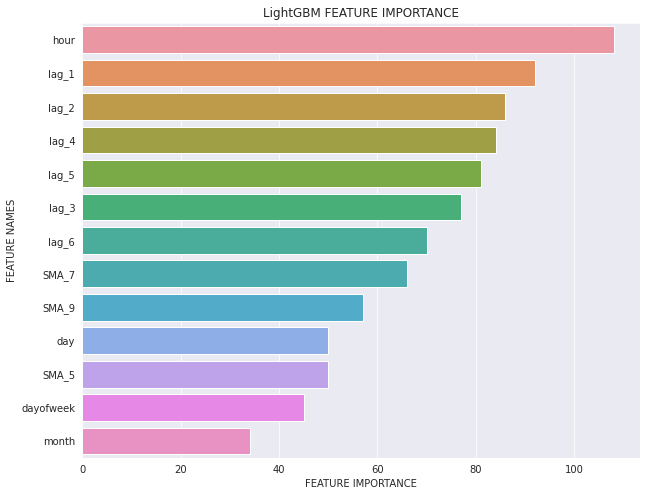

In [55]:
plot_feature_importance(model_2.feature_importances_,X_test.columns,'LightGBM ')

Seems like "hour" is the most important feature in our dataset. Suprisingly, the "dayofweek" is not as important as we previously thought. 

 Let's visualy inspect how well our predictions worked against the actual orders:

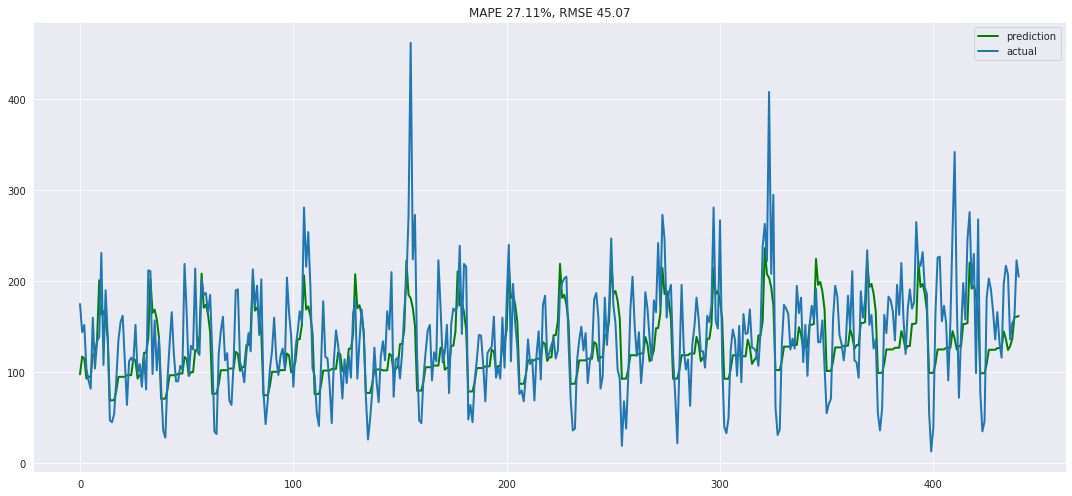

In [96]:
plotModelResults(model_2, X_train, X_test, y_train, y_test)

<div class="alert alert-success">
<b>Reviewer's comment</b>

The final model was evaluated on the test set

</div>

# Review checklist

- [x]  Jupyter Notebook is open
- [ ]  The code is error-free
- [ ]  The cells with the code have been arranged in order of execution
- [ ]  The data has been downloaded and prepared
- [ ]  The data has been analyzed
- [ ]  The model has been trained and hyperparameters have been selected
- [ ]  The models have been evaluated. Conclusion has been provided
- [ ] *RMSE* for the test set is not more than 48